<a href="https://colab.research.google.com/github/kushalgowdagv/Beta-Backtest/blob/master/ETF_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# ETFs to analyze
etf_list = [
    "SPY", "QQQ", "DIA", "IWM", "EFA", "XLK", "XLY", "XLF", "IBB", "ARKK",
    "XLE", "XLV", "XLC", "XLU", "XLI", "XLB", "XLP", "VNQ", "TLT", "GLD"
]

# Parameters
lookback_period = 252
top_n = 10

# Download historical price data
data = yf.download(etf_list, period="2y", interval="1d")
print("Available columns:", data.columns)

# Extract close prices
price_data = data.xs("Close", level=0, axis=1) if isinstance(data.columns, pd.MultiIndex) else data

# Nearness to Highs (NH)
rolling_highs = price_data.rolling(window=lookback_period, min_periods=1).max()
nearness_to_highs = (price_data.iloc[-1] / rolling_highs.iloc[-1]) * 100

# Rate of Change (ROC)
roc = ((price_data.iloc[-1] - price_data.iloc[-lookback_period]) / price_data.iloc[-lookback_period]) * 100

# Volatility: Std dev of daily returns over the lookback period
returns = price_data.pct_change().dropna()
volatility = returns.rolling(window=lookback_period).std().iloc[-1]

# Combine metrics into DataFrame
momentum_etfs = pd.DataFrame({
    "NH (%)": nearness_to_highs,
    "ROC (%)": roc,
    "Volatility": volatility
}).dropna()

# Filter by NH > 90% and ROC > 10%
filtered_etfs = momentum_etfs[(momentum_etfs["NH (%)"] > 90) & (momentum_etfs["ROC (%)"] > 10)]

# Rank and select top N ETFs based on ROC
top_etfs = filtered_etfs.sort_values(by="ROC (%)", ascending=False).head(top_n)

# Weighting strategies
momentum_weights = top_etfs["ROC (%)"] / top_etfs["ROC (%)"].sum()
inverse_volatility = 1 / top_etfs["Volatility"]
volatility_weights = inverse_volatility / inverse_volatility.sum()
equal_weights = np.ones(len(top_etfs)) / len(top_etfs)

# Final blended weights
final_weights = (momentum_weights + volatility_weights + equal_weights) / 3
final_weights /= final_weights.sum()  # Normalize

# Add weights to DataFrame
top_etfs["Momentum Weight %"] = (momentum_weights * 100).round(2)
top_etfs["Volatility Weight %"] = (volatility_weights * 100).round(2)
top_etfs["Equal Weight %"] = (equal_weights * 100).round(2)
top_etfs["Final Weight"] = final_weights
top_etfs["Final Weight %"] = (final_weights * 100).round(2)

# Final portfolio allocation
print(top_etfs[["NH (%)", "ROC (%)", "Volatility", "Momentum Weight %", "Volatility Weight %", "Equal Weight %", "Final Weight %"]])


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


Available columns: MultiIndex([( 'Close', 'ARKK'),
            ( 'Close',  'DIA'),
            ( 'Close',  'EFA'),
            ( 'Close',  'GLD'),
            ( 'Close',  'IBB'),
            ( 'Close',  'IWM'),
            ( 'Close',  'QQQ'),
            ( 'Close',  'SPY'),
            ( 'Close',  'TLT'),
            ( 'Close',  'VNQ'),
            ( 'Close',  'XLB'),
            ( 'Close',  'XLC'),
            ( 'Close',  'XLE'),
            ( 'Close',  'XLF'),
            ( 'Close',  'XLI'),
            ( 'Close',  'XLK'),
            ( 'Close',  'XLP'),
            ( 'Close',  'XLU'),
            ( 'Close',  'XLV'),
            ( 'Close',  'XLY'),
            (  'High', 'ARKK'),
            (  'High',  'DIA'),
            (  'High',  'EFA'),
            (  'High',  'GLD'),
            (  'High',  'IBB'),
            (  'High',  'IWM'),
            (  'High',  'QQQ'),
            (  'High',  'SPY'),
            (  'High',  'TLT'),
            (  'High',  'VNQ'),
            (  'High'

# New Section

<ipython-input-12-b58bd5ad5bfe>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = price_data.resample(rebalance_frequency).last().index
<ipython-input-12-b58bd5ad5bfe>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34106893 0.33385282 0.32507825]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[score_weights.index] = score_weights
<ipython-input-12-b58bd5ad5bfe>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34356512 0.33608204 0.32035283]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[score_weights.index] = score_weights
<ipython-input-12-b58bd5ad5bfe>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will r

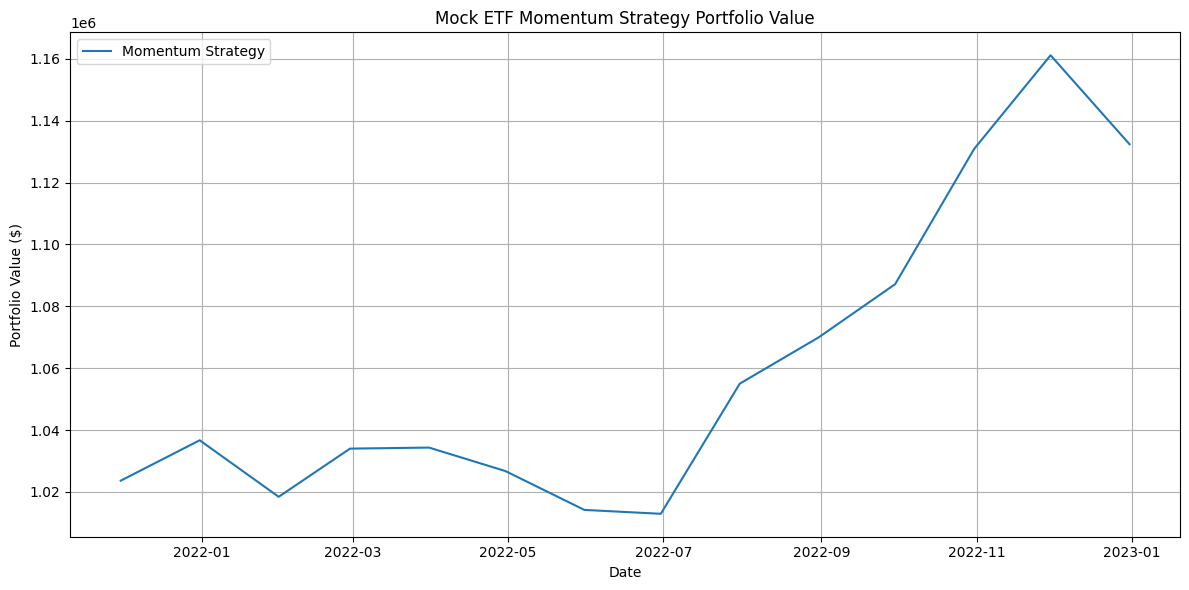


Performance Summary:
CAGR: 9.76%
Sharpe Ratio: 1.33
Max Drawdown: -2.48%

Final Holdings:
{'ETF3': 2709.2064261021696, 'ETF4': 3117.7745793876006, 'ETF9': 4238.7478517304135}


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------- #
# Mock ETF Price Data Generator
# ----------------------------- #
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", end="2022-12-31", freq="B")  # Business days
etf_names = [f"ETF{i}" for i in range(1, 11)]
price_data = pd.DataFrame(index=dates)

for etf in etf_names:
    price = 100
    returns = np.random.normal(loc=0.0003, scale=0.01, size=len(dates))
    price_series = price * (1 + returns).cumprod()
    price_data[etf] = price_series

# ----------------------------- #
# Strategy Parameters
# ----------------------------- #
lookback_period = 21  # 1-month lookback
rebalance_frequency = 'M'
top_n = 3
initial_capital = 1_000_000

# ----------------------------- #
# Backtest Setup
# ----------------------------- #
rebalance_dates = price_data.resample(rebalance_frequency).last().index
portfolio_value = [initial_capital]
portfolio_history = []

# ----------------------------- #
# Backtest Logic
# ----------------------------- #
for i in range(lookback_period, len(rebalance_dates) - 1):
    date = rebalance_dates[i]
    next_date = rebalance_dates[i + 1]

    past_data = price_data.loc[:date].iloc[-lookback_period:]

    roc = (past_data.iloc[-1] - past_data.iloc[0]) / past_data.iloc[0] * 100
    rolling_high = past_data.max()
    nh = (past_data.iloc[-1] / rolling_high) * 100

    momentum = pd.DataFrame({"ROC (%)": roc, "NH (%)": nh}).dropna()
    momentum["Score"] = 0.5 * momentum["ROC (%)"] + 0.5 * momentum["NH (%)"]

    selected = momentum.sort_values(by="Score", ascending=False).head(min(top_n, len(momentum)))
    weights = pd.Series(0, index=price_data.columns)
    score_weights = selected["Score"] / selected["Score"].sum()
    weights.loc[score_weights.index] = score_weights

    current_prices = price_data.loc[:date].iloc[-1]
    future_prices = price_data.loc[:next_date].iloc[-1]

    shares = (portfolio_value[-1] * weights / current_prices).fillna(0)
    port_val = (shares * future_prices).sum()

    portfolio_value.append(port_val)
    portfolio_history.append({
        "Date": next_date,
        "Value": port_val,
        "Holdings": shares[shares > 0].to_dict()
    })

# ----------------------------- #
# Results & Visualization
# ----------------------------- #
results_df = pd.DataFrame(portfolio_history)
results_df.set_index("Date", inplace=True)

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(results_df["Value"], label="Momentum Strategy")
plt.title("Mock ETF Momentum Strategy Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------- #
# Performance Metrics
# ----------------------------- #
returns = results_df["Value"].pct_change().dropna()
cagr = (results_df["Value"].iloc[-1] / results_df["Value"].iloc[0]) ** (1 / ((results_df.index[-1] - results_df.index[0]).days / 365.25)) - 1
sharpe = returns.mean() / returns.std() * np.sqrt(12)
max_drawdown = ((results_df["Value"] / results_df["Value"].cummax()) - 1).min()

# Print performance summary
print("\nPerformance Summary:")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# Show final holdings
print("\nFinal Holdings:")
print(results_df["Holdings"].iloc[-1])


# Task
convert the ticker column from csv into list

Here is all the data you need:
"yahoo_etfs_full_list.csv"

## Data loading

### Subtask:
Load the ETF data from the provided CSV file.


**Reasoning**:
I need to import the pandas library and load the CSV file into a DataFrame named `df_etfs`.



In [2]:
import pandas as pd

try:
    df_etfs = pd.read_csv('yahoo_etfs_full_list.csv')
    display(df_etfs.head())
except FileNotFoundError:
    print("Error: 'yahoo_etfs_full_list.csv' not found. Please ensure the file is in the current directory or provide the correct path.")
    df_etfs = None

Error: 'yahoo_etfs_full_list.csv' not found. Please ensure the file is in the current directory or provide the correct path.


## Data exploration

### Subtask:
Explore the loaded DataFrame, focusing on the 'ticker' column.


**Reasoning**:
Verify the dataframe and check the 'Ticker' column's properties.



In [3]:
if df_etfs is None or df_etfs.empty:
    print("Error: DataFrame 'df_etfs' is empty or does not exist.")
else:
    print("Column names:", df_etfs.columns.tolist())
    ticker_column_name = 'Ticker'  # Assuming 'Ticker' column exists
    print("Data type of ticker column:", df_etfs[ticker_column_name].dtype)
    print("First few rows of ticker column:")
    display(df_etfs[ticker_column_name].head())

Error: DataFrame 'df_etfs' is empty or does not exist.


## Data wrangling

### Subtask:
Extract the 'Ticker' column from the DataFrame `df_etfs` and convert it into a Python list.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Reasoning**:
Extract the 'Ticker' column from the DataFrame `df_etfs` and convert it into a Python list named `ticker_list`.



In [17]:
ticker_list = df_etfs['Ticker'].tolist()
print(f"The first 5 tickers in the list are: {ticker_list[:5]}")

The first 5 tickers in the list are: ['VXUS', 'BND', 'QQQ', 'BNDX', 'VTIP']


In [20]:
len(ticker_list)

1000

In [21]:
import yfinance as yf
import pandas as pd

# ticker_list = ['VXUS', 'BND', 'QQQ', 'BNDX', 'VTIP']

data = yf.download(ticker_list, period="max", interval="1d")
adj_close_prices = data['Close']

# Rename columns
adj_close_prices = adj_close_prices.add_suffix('_Close')

# The merged DataFrame is now adj_close_prices
print(adj_close_prices.head()) # To see the output, run the code.


[*********************100%***********************]  100 of 100 completed


Ticker      AAXJ_Close  ACWI_Close  ACWX_Close  AIQ_Close  AIRR_Close  \
Date                                                                    
1999-03-10         NaN         NaN         NaN        NaN         NaN   
1999-03-11         NaN         NaN         NaN        NaN         NaN   
1999-03-12         NaN         NaN         NaN        NaN         NaN   
1999-03-15         NaN         NaN         NaN        NaN         NaN   
1999-03-16         NaN         NaN         NaN        NaN         NaN   

Ticker      ANGL_Close  BND_Close  BNDX_Close  BOTZ_Close  BSCP_Close  ...  \
Date                                                                   ...   
1999-03-10         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-11         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-12         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-15         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-16         N

In [22]:
adj_close_prices

Ticker,AAXJ_Close,ACWI_Close,ACWX_Close,AIQ_Close,AIRR_Close,ANGL_Close,BND_Close,BNDX_Close,BOTZ_Close,BSCP_Close,...,VONE_Close,VONG_Close,VONV_Close,VTHR_Close,VTIP_Close,VTWO_Close,VWOB_Close,VXUS_Close,VYMI_Close,XT_Close
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21,75.769997,117.980003,56.650002,37.840000,69.629997,28.940001,73.320000,48.660000,30.340000,20.660999,...,256.410461,95.175980,82.111053,249.451767,49.619999,82.348091,64.400002,63.459999,74.629997,59.869999
2025-03-24,76.059998,119.709999,56.790001,38.599998,71.919998,29.030001,73.000000,48.610001,30.680000,20.665001,...,261.165985,97.292999,83.205994,253.977997,49.560001,84.421997,64.349998,63.560001,74.639999,60.439999
2025-03-25,75.830002,119.769997,56.990002,38.689999,71.750000,28.990000,73.089996,48.619999,30.740000,20.660000,...,261.799988,97.839996,83.180000,254.410004,49.619999,83.959999,64.410004,63.770000,75.139999,60.450001


In [23]:
len(adj_close_prices.columns)

100

In [24]:
import yfinance as yf
import pandas as pd

# Assuming ticker_list contains all your tickers
# ticker_list = df_etfs['Ticker'].tolist()  # From your previous code

# Function to download data in chunks
def download_data_in_chunks(ticker_list, chunk_size=100):
    final_df = pd.DataFrame()
    for i in range(0, len(ticker_list), chunk_size):
        chunk = ticker_list[i:i + chunk_size]
        data = yf.download(chunk, period="max", interval="1d")
        adj_close_prices = data['Close']
        adj_close_prices = adj_close_prices.add_suffix('_Close')  # Rename columns
        final_df = pd.concat([final_df, adj_close_prices], axis=1)
    return final_df

# Download data in chunks of 100
adj_close_prices = download_data_in_chunks(ticker_list)

print(adj_close_prices.head())  # To see the output, run the code.

[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed
[*********************100%***********************]  100 of 100 completed


Ticker      AAXJ_Close  ACWI_Close  ACWX_Close  AIQ_Close  AIRR_Close  \
Date                                                                    
1999-03-10         NaN         NaN         NaN        NaN         NaN   
1999-03-11         NaN         NaN         NaN        NaN         NaN   
1999-03-12         NaN         NaN         NaN        NaN         NaN   
1999-03-15         NaN         NaN         NaN        NaN         NaN   
1999-03-16         NaN         NaN         NaN        NaN         NaN   

Ticker      ANGL_Close  BND_Close  BNDX_Close  BOTZ_Close  BSCP_Close  ...  \
Date                                                                   ...   
1999-03-10         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-11         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-12         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-15         NaN        NaN         NaN         NaN         NaN  ...   
1999-03-16         N

In [26]:
adj_close_prices.to_csv('adj_close_prices.csv')

In [27]:
adj_close_prices

Ticker,AAXJ_Close,ACWI_Close,ACWX_Close,AIQ_Close,AIRR_Close,ANGL_Close,BND_Close,BNDX_Close,BOTZ_Close,BSCP_Close,...,VONE_Close,VONG_Close,VONV_Close,VTHR_Close,VTIP_Close,VTWO_Close,VWOB_Close,VXUS_Close,VYMI_Close,XT_Close
Date,,,,,,,,,,,,,,,,,,,,,
1999-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21,75.769997,117.980003,56.650002,37.840000,69.629997,28.940001,73.320000,48.660000,30.340000,20.660999,...,256.410461,95.175980,82.111053,249.451767,49.619999,82.348091,64.400002,63.459999,74.629997,59.869999
2025-03-24,76.059998,119.709999,56.790001,38.599998,71.919998,29.030001,73.000000,48.610001,30.680000,20.665001,...,261.165985,97.292999,83.205994,253.977997,49.560001,84.421997,64.349998,63.560001,74.639999,60.439999
2025-03-25,75.830002,119.769997,56.990002,38.689999,71.750000,28.990000,73.089996,48.619999,30.740000,20.660000,...,261.799988,97.839996,83.180000,254.410004,49.619999,83.959999,64.410004,63.770000,75.139999,60.450001


In [1]:

adj_close_prices = adj_close_prices.dropna(axis=1, how='all')
adj_close_prices # To see the output, run the code.

NameError: name 'adj_close_prices' is not defined

In [38]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=2668bf6c0dbe49c25565fffc2317156b148664b7b883c838ad2f59001490dc85
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [52]:
pip install -U git+https://github.com/twopirllc/pandas-ta


  Cloning https://github.com/twopirllc/pandas-ta to /tmp/pip-req-build-gkm2tafz
  Running command git clone --filter=blob:none --quiet https://github.com/twopirllc/pandas-ta /tmp/pip-req-build-gkm2tafz
  Resolved https://github.com/twopirllc/pandas-ta to commit b465491f226d9e07fffd4e59cd0affc9284521ca
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [48]:
!pip install numpy==1.23.5 --upgrade --quiet
!pip install pandas_ta --upgrade --quiet


In [55]:
df=adj_close_prices.copy()

In [57]:
import pandas as pd
import numpy as np

# === CONFIGURABLE PARAMETERS ===
lookback_return = 63  # ~3 months
rsi_period = 14
ma_period = 50
top_n_percent = 20  # top 20%
entry_rsi_threshold = 60
exit_rsi_threshold = 50

# === FUNCTION TO CALCULATE RSI MANUALLY ===
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    rsi = 100 - (100 / (1 + rs))
    return rsi

# === PREPROCESSING ===
df = df.copy()
# Only select columns that end with '_Close'
close_cols = [col for col in df.columns if col.endswith('_Close')]
tickers = [col.replace('_Close', '') for col in close_cols]

# tickers = [col.replace('_Close', '') for col in df.columns if col.endswith('_Close')]

signals = {}

for ticker in tickers:
    price = df[f"{ticker}_Close"]
    ticker_df = pd.DataFrame(index=df.index)
    ticker_df['Price'] = price

    # Momentum (Return over lookback period)
    ticker_df['Return'] = price.pct_change(lookback_return)

    # RSI
    ticker_df['RSI'] = compute_rsi(price, rsi_period)

    # 50-day Moving Average
    ticker_df['MA50'] = price.rolling(ma_period).mean()

    # Entry condition
    ticker_df['Signal'] = 0
    ticker_df.loc[
        (ticker_df['RSI'] > entry_rsi_threshold) &
        (ticker_df['Price'] > ticker_df['MA50']),
        'Signal'
    ] = 1  # Buy signal

    # Exit condition
    ticker_df.loc[
        (ticker_df['RSI'] < exit_rsi_threshold) |
        (ticker_df['Price'] < ticker_df['MA50']),
        'Signal'
    ] = 0  # Exit signal

    signals[ticker] = ticker_df

# === CREATE A MASTER SIGNAL DATAFRAME (for easy viewing) ===
signal_df = pd.DataFrame({ticker: signals[ticker]['Signal'] for ticker in signals})

# === RANKING FOR TOP N% MOMENTUM PICKS ===
returns_df = pd.DataFrame({ticker: signals[ticker]['Return'] for ticker in signals})
ranked_df = returns_df.rank(axis=1, ascending=False, pct=True)
top_momentum = ranked_df >= (1 - top_n_percent / 100)

# === FINAL STRATEGY SIGNAL ===
# Only go long when signal is 1 **and** in top 20% performers
final_signals = signal_df * top_momentum

# Optional: Forward fill positions (hold if no sell signal)
positions = final_signals.replace(0, np.nan).ffill().fillna(0)

# === Done! You can now backtest positions ===


ValueError: Cannot set a DataFrame with multiple columns to the single column Price

In [54]:
import pandas as pd
import numpy as np
from numpy import NaN as npNaN

import pandas_ta as ta
import matplotlib.pyplot as plt

# Assume df is your input DataFrame with multi-ticker columns
# Step 1: Clean Data
df = df.dropna(axis=1, how='all').fillna(method='ffill')
returns = df.pct_change()

# Step 2: Calculate 3-month momentum (63 trading days)
momentum = df.pct_change(periods=63)

# Step 3: Calculate RSI(14) and 50-day moving average using pandas_ta
rsi = pd.DataFrame(index=df.index)
ma50 = df.rolling(window=50).mean()

for col in df.columns:
    rsi[col] = ta.rsi(df[col], length=14)

# Step 4: Signal Generation
signal = pd.DataFrame(index=df.index, columns=df.columns)

for date in df.index[63:]:
    daily_momentum = momentum.loc[date]
    top_assets = daily_momentum[daily_momentum.rank(pct=True) >= 0.80].index

    for ticker in top_assets:
        try:
            if (rsi.at[date, ticker] > 60) and (df.at[date, ticker] > ma50.at[date, ticker]):
                signal.at[date, ticker] = 1
        except:
            continue

# Step 5: Simulate Holding Period of 10 Days
positions = signal.copy()
holding_period = 10

for date in signal.index:
    if date not in df.index:
        continue
    for ticker in signal.columns:
        if signal.at[date, ticker] == 1:
            for i in range(holding_period):
                future_date_idx = df.index.get_loc(date) + i
                if future_date_idx < len(df.index):
                    future_date = df.index[future_date_idx]
                    positions.at[future_date, ticker] = 1

# Step 6: Calculate Portfolio Returns
daily_strategy_returns = (returns * positions.shift(1)).mean(axis=1)
cumulative_returns = (1 + daily_strategy_returns.fillna(0)).cumprod()

# Step 7: Performance Metrics
def performance_metrics(ret):
    ann_return = ret.mean() * 252
    ann_vol = ret.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return {
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': drawdown
    }

metrics = performance_metrics(daily_strategy_returns)

# Print Results
print("Performance Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2%}")

# Plot
cumulative_returns.plot(title='Momentum Strategy Cumulative Returns', figsize=(12,6))
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


ImportError: cannot import name 'NaN' from 'numpy' (/usr/local/lib/python3.11/dist-packages/numpy/__init__.py)

In [44]:
import pandas as pd
import numpy as np
import talib
from datetime import timedelta

# Assume df is your input DataFrame
# Clean up: drop columns with all NaN and forward-fill missing data
df = df.dropna(axis=1, how='all').fillna(method='ffill')

# Calculate daily returns
returns = df.pct_change()

# 1. Calculate momentum over 3 months (~63 trading days)
momentum = df.pct_change(periods=63)

# 2. RSI and 50-day moving average
rsi = df.apply(lambda x: talib.RSI(x.values, timeperiod=14), axis=0)
ma50 = df.rolling(window=50).mean()

# 3. Signal: momentum in top 20%, RSI > 60, Price > MA50
signal = pd.DataFrame(index=df.index, columns=df.columns)

for date in df.index[63:]:  # start after enough history
    # Momentum ranks
    daily_momentum = momentum.loc[date]
    top_assets = daily_momentum[daily_momentum.rank(pct=True) >= 0.80].index

    for ticker in top_assets:
        try:
            if (rsi.at[date, ticker] > 60) and (df.at[date, ticker] > ma50.at[date, ticker]):
                signal.at[date, ticker] = 1
        except:
            continue

# 4. Backtest logic: Buy on signal, hold for 10 days
positions = signal.copy()
holding_period = 10

for date in signal.index:
    if date not in df.index:
        continue
    for ticker in signal.columns:
        if signal.at[date, ticker] == 1:
            for i in range(holding_period):
                future_date_idx = df.index.get_loc(date) + i
                if future_date_idx < len(df.index):
                    future_date = df.index[future_date_idx]
                    positions.at[future_date, ticker] = 1

# 5. Portfolio returns: equally weighted
daily_strategy_returns = (returns * positions.shift(1)).mean(axis=1)

# 6. Cumulative returns
cumulative_returns = (1 + daily_strategy_returns.fillna(0)).cumprod()

# 7. Performance summary
def performance_metrics(ret):
    annualized_return = ret.mean() * 252
    annualized_vol = ret.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

metrics = performance_metrics(daily_strategy_returns)

# Output results
print("Performance Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.2%}")

# Optional: Plot cumulative return
import matplotlib.pyplot as plt
cumulative_returns.plot(title='Momentum Strategy Cumulative Returns', figsize=(12,6))
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'talib'